In [5]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D,Input,concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [6]:
images = '/kaggle/input/semantic-segmentation-2/semantic segmentation/Images'
labels = '/kaggle/input/semantic-segmentation-2/semantic segmentation/Labels'

In [8]:
num_classes = 2
masks = np.round(masks).astype("int")  # Ensure masks are binary
masks = to_categorical(masks, num_classes=num_classes)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)
print(X_val.shape)

(143, 128, 128, 3)
(36, 128, 128, 3)


In [11]:
def unet_model(input_size=(128, 128, 3), num_classes=num_classes):
    inputs = Input(input_size)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (Expanding Path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = unet_model(input_size=(128, 128, 3))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]

 Total params: 31,379,010 (119.70 MB)

 Trainable params: 31,379,010 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8756 - loss: 0.4806 - val_accuracy: 0.7408 - val_loss: 0.5466
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.7940 - loss: 0.4778 - val_accuracy: 0.7942 - val_loss: 0.4503
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.8387 - loss: 0.3682 - val_accuracy: 0.7993 - val_loss: 0.4313
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.8576 - loss: 0.3394 - val_accuracy: 0.8057 - val_loss: 0.4310
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.8735 - loss: 0.3046 - val_accuracy: 0.8187 - val_loss: 0.4136
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.8949 - loss: 0.2569 - val_accuracy: 0.8335 - val_loss: 0.3857
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.9007 - loss: 0.2420 - val_accuracy: 0.8243 - val_loss: 0.4292
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 0.9119 - loss: 0.2205 - val_accuracy: 0.8205 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


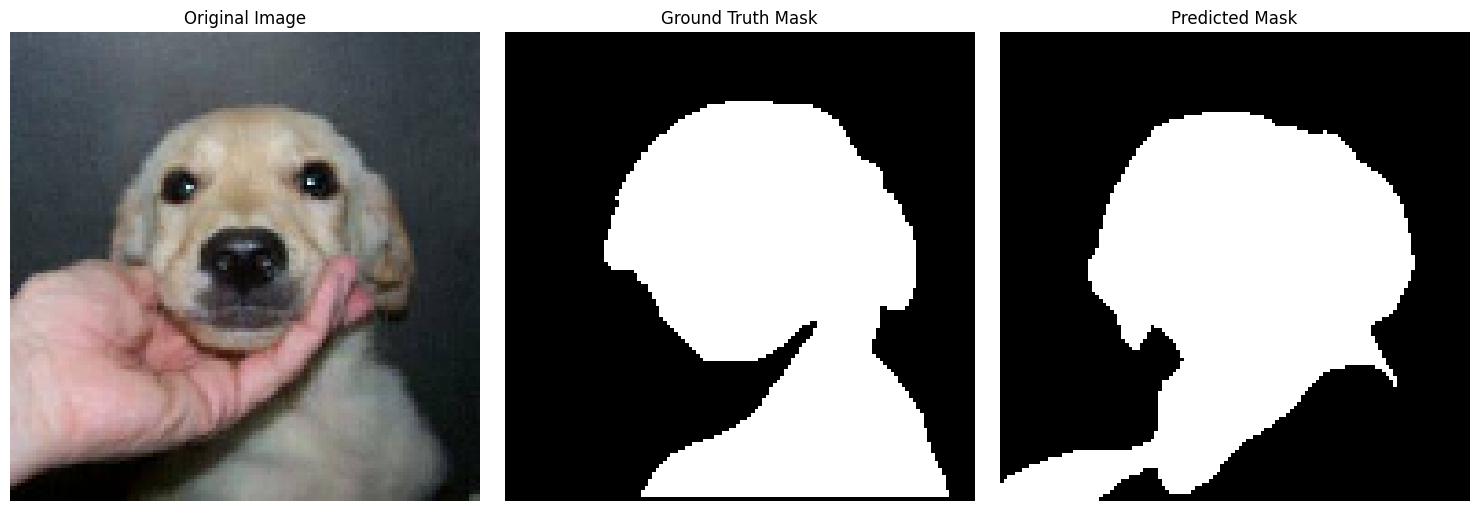

In [41]:
import matplotlib.pyplot as plt

# Randomly select an image from x_test
random_index = 10
random_image = X_val[random_index]
random_image = np.expand_dims(random_image, axis=0)  # Add batch dimension

# Predict segmentation mask
predicted_mask = model.predict(random_image)

# Convert softmax probabilities to class indices
predicted_mask = tf.argmax(predicted_mask, axis=-1)  # Shape: (batch_size, height, width)

# Add an additional axis to match the required shape (optional, for compatibility)
predicted_mask = predicted_mask[..., tf.newaxis]  # Shape: (batch_size, height, width, 1)

# Convert TensorFlow tensor to NumPy array for visualization
predicted_mask_np = predicted_mask.numpy()[0, ..., 0]  # Remove batch and channel dimensions

# Ground truth mask
true_mask = y_val[random_index]
true_mask_single = np.argmax(true_mask, axis=-1)  # Convert one-hot to single-channel

# Display the original image, true mask, and predicted mask
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(random_image.squeeze(), cmap='gray')  # Assuming grayscale input
plt.title("Original Image")
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask_single, cmap='gray')  # Display single-channel mask
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_np, cmap='gray')  # Display single-channel predicted mask
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
